# 🌧️ Indigenous Rainfall Forecasting Using Ecological Indicators

### Project Overview
Across Ghana’s Pra River Basin, local farmers have long relied on **Indigenous Ecological Indicators (IEIs)**—such as the sun, clouds, moon, wind, trees, and animal behavior—to forecast rainfall.  
This project digitizes these forecasts via the **Smart Indigenous Weather App** and uses machine learning to predict **rainfall type** in the next 12–24 hours.


## 🎯 Objective
The objective of this challenge is to **predict rainfall type** — 
- Heavy  
- Moderate  
- Small  

based solely on **indigenous ecological indicators** submitted by farmers, along with their forecast horizon (12h or 24h).  

This project explores how **AI can validate and strengthen indigenous climate wisdom**, enabling **hyper-local weather prediction** where conventional models often fail.


### Load essential libraries

In [2]:
%pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Load dataset directly from GitHub (raw content)
train_url = "https://raw.githubusercontent.com/victorkelechi/Indigenous-Weather-ML/main/Train_data.csv"
test_url = "https://raw.githubusercontent.com/victorkelechi/Indigenous-Weather-ML/main/Test_data.csv"

# Read CSV files
train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

# read first few rows
train_data.head()


,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,NaN,NaN,HEAVYRAIN,12


In [5]:
# Check how many indicator used by farmers
train_data["indicator"].value_counts()

indicator
clouds       266
sun           90
heat          53
fog           27
wind          25
moon          19
dew            9
star           8
thunder        4
lightning      2
Name: count, dtype: int64

In [6]:
# Understanding the data
print(train_data.shape)
print(test_data.shape)

(10928, 12)
(2732, 11)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10928 entries, 0 to 10927
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10928 non-null  object 
 1   user_id                10928 non-null  int64  
 2   confidence             10928 non-null  float64
 3   predicted_intensity    10928 non-null  float64
 4   community              10928 non-null  object 
 5   district               10928 non-null  object 
 6   prediction_time        10928 non-null  object 
 7   indicator              503 non-null    object 
 8   indicator_description  346 non-null    object 
 9   time_observed          72 non-null     object 
 10  Target                 10928 non-null  object 
 11  forecast_length        10928 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 1.0+ MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732 entries, 0 to 2731
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     2732 non-null   object 
 1   user_id                2732 non-null   int64  
 2   confidence             2732 non-null   float64
 3   predicted_intensity    2732 non-null   float64
 4   community              2732 non-null   object 
 5   district               2732 non-null   object 
 6   prediction_time        2732 non-null   object 
 7   indicator              205 non-null    object 
 8   indicator_description  205 non-null    object 
 9   time_observed          205 non-null    object 
 10  forecast_length        2732 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 234.9+ KB


#### Looking at the two datasets, some of the columns are not in the right format; let's format them rightly.

In [9]:
# Write a function to do the conversion
def format_dataset(df):
  drop_cols = ["indicator_description", "time_observed"]
  df = df.drop(drop_cols, axis = 1)

  # user_id to object
  if "user_id" in df.columns:
    df["user_id"] = df["user_id"].astype("object")

  # Prediction_time to datatime format
  if "prediction_time" in df.columns:
    df["prediction_time"] = pd.to_datetime(df["prediction_time"], errors = "coerce")

  # indicator to categorical
  if "indicator" in df.columns:
    df["indicator"] = df["indicator"].astype("category")

  # Target to categorical
  if "Target" in df.columns:
    df["Target"] = df["Target"].astype("category")

  return df

In [10]:
train_data = format_dataset(train_data)
test_data = format_dataset(test_data)

# Missing values

In [11]:
def impute_indicators(
    df,
    user_col='user_id',
    time_col='prediction_time',
    indicator_col='indicator',
    community_col='community',
    forecast_col='forecast_length',
    time_window_hours=1):
    for c in [user_col, time_col, forecast_col, community_col, indicator_col]:
        if c not in df.columns:
            raise ValueError(f"Required column '{c}' not found")
    # keep originals
    df['indicator_original'] = df[indicator_col]
    df['indicator_imputed'] = df[indicator_col]

    total_missing_start = df['indicator_imputed'].isna().sum()
    time_tol = pd.Timedelta(hours=time_window_hours)

    # Nearest known by same user & forecast_length within tolerance
    known = df[df['indicator_imputed'].notna()].copy().sort_values(time_col)
    missing = df[df['indicator_imputed'].isna()].copy().sort_values(time_col)
    filled_stage1 = 0

    if not known.empty and not missing.empty:
        known_for_merge = known[[user_col, forecast_col, time_col, 'indicator_imputed']].copy()
        known_for_merge = known_for_merge.sort_values(time_col).rename(columns={'indicator_imputed':'indicator_known'})
        known_for_merge['known_time'] = known_for_merge[time_col]
        missing = missing.reset_index().rename(columns={'index':'orig_index'})
        prev = pd.merge_asof(missing.sort_values(time_col),
                             known_for_merge,
                             on=time_col,
                             by=[user_col, forecast_col],
                             direction='backward',
                             tolerance=time_tol)

        prev = prev[['orig_index','indicator_known','known_time']].rename(columns={'indicator_known':'indicator_prev','known_time':'time_prev'})
        nxt = pd.merge_asof(missing.sort_values(time_col),
                            known_for_merge,
                            on=time_col,
                            by=[user_col, forecast_col],
                            direction='forward',
                            tolerance=time_tol)
        nxt = nxt[['orig_index','indicator_known','known_time']].rename(columns={'indicator_known':'indicator_next','known_time':'time_next'})
        cand = missing[['orig_index', time_col]].merge(prev, on='orig_index', how='left').merge(nxt, on='orig_index', how='left')
        def choose_nearest(row):
            t = row[time_col]
            ind_prev = row.get('indicator_prev')
            t_prev = row.get('time_prev')
            ind_next = row.get('indicator_next')
            t_next = row.get('time_next')
            if pd.notna(t_prev):
                del_prev = t - t_prev
            else:
                del_prev = pd.NaT

            if pd.notna(t_next):
                del_next = t_next - t
            else:
                del_next = pd.NaT

            if pd.notna(del_prev) and pd.notna(del_next):
                return ind_prev if del_prev <= del_next else ind_next
            elif pd.notna(del_prev):
                return ind_prev
            elif pd.notna(del_next):
                return ind_next
            else:
                return None
        cand['chosen_time_indicator'] = cand.apply(choose_nearest, axis=1)
        assign_map = cand.set_index('orig_index')['chosen_time_indicator'].to_dict()
        for orig_idx, val in assign_map.items():
            if pd.notna(val):
                df.at[orig_idx, 'indicator_imputed'] = val
                filled_stage1 += 1

    # farmer's mode in same community & forecast_length
    filled_stage2 = 0
    remaining_mask = df['indicator_imputed'].isna()
    if remaining_mask.any():
        modes_fcm = df[~df['indicator_imputed'].isna()].groupby([user_col, community_col, forecast_col])['indicator_imputed'] \
.agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan).to_dict()
        for idx in df[remaining_mask].index:
            key = (df.at[idx, user_col], df.at[idx, community_col], df.at[idx, forecast_col])
            val = modes_fcm.get(key, np.nan)
            if pd.notna(val):
                df.at[idx, 'indicator_imputed'] = val
                filled_stage2 += 1

    # farmer global mode for forecast_length
    filled_stage3 = 0
    remaining_mask = df['indicator_imputed'].isna()
    if remaining_mask.any():
        modes_f_flen = df[~df['indicator_imputed'].isna()].groupby([user_col, forecast_col])['indicator_imputed'] \
.agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan).to_dict()
        for idx in df[remaining_mask].index:
            key = (df.at[idx, user_col], df.at[idx, forecast_col])
            val = modes_f_flen.get(key, np.nan)
            if pd.notna(val):
                df.at[idx, 'indicator_imputed'] = val
                filled_stage3 += 1

    # dataset-level mode for forecast_length
    filled_stage4 = 0
    remaining_mask = df['indicator_imputed'].isna()
    if remaining_mask.any():
        ds_mode_by_fl = df[~df['indicator_imputed'].isna()].groupby(forecast_col)['indicator_imputed'] \
.agg(lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan).to_dict()
        for idx in df[remaining_mask].index:
            key = df.at[idx, forecast_col]
            val = ds_mode_by_fl.get(key, np.nan)
            if pd.notna(val):
                df.at[idx, 'indicator_imputed'] = val
                filled_stage4 += 1
    # final overall mode
    filled_stage5 = 0
    remaining_mask = df['indicator_imputed'].isna()
    if remaining_mask.any():
        overall_mode = df['indicator_imputed'].mode()
        if not overall_mode.empty:
            overall_mode = overall_mode.iloc[0]
            df.loc[remaining_mask, 'indicator_imputed'] = overall_mode
            filled_stage5 = remaining_mask.sum()

    summary = {
        'total_missing_start': int(total_missing_start),
        'filled_stage1_time_proximity': int(filled_stage1),
        'filled_stage2_farmer_community_mode': int(filled_stage2),
        'filled_stage3_farmer_forecast_mode': int(filled_stage3),
        'filled_stage4_dataset_forecast_mode': int(filled_stage4),
        'filled_stage5_overall_mode': int(filled_stage5),
        'total_missing_end': int(df['indicator_imputed'].isna().sum())
    }
    return df, summary

In [12]:
train_data, summary = impute_indicators(train_data, time_window_hours=2)
train_data

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,Target,forecast_length,indicator_original,indicator_imputed
0,ID_KwcTp_12,11,0.3,0.00,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,MEDIUMRAIN,12,NaN,sun
1,ID_K9vWT_12,17,0.3,0.00,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,HEAVYRAIN,12,NaN,clouds
2,ID_AIQg3_12,19,0.3,0.00,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,MEDIUMRAIN,12,NaN,clouds
3,ID_px4yf_12,23,0.3,0.00,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,HEAVYRAIN,12,NaN,heat
4,ID_QYYmK_12,23,0.3,0.00,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,HEAVYRAIN,12,NaN,heat
...,...,...,...,...,...,...,...,...,...,...,...,...
10923,ID_GSbJj_24,18,0.3,0.00,Akwaduuso,assin_fosu,2025-07-20 19:13:17,NaN,NORAIN,24,NaN,heat
10924,ID_h8Ny4_24,18,0.3,0.00,Akwaduuso,assin_fosu,2025-07-20 19:13:19,NaN,NORAIN,24,NaN,heat
10925,ID_90CwG_24,18,0.3,0.00,Akwaduuso,assin_fosu,2025-07-20 19:13:21,NaN,NORAIN,24,NaN,heat
10926,ID_GAaTk_24,57,0.6,0.33,Assin Aponsie,assin_fosu,2025-07-20 19:18:39,clouds,NORAIN,24,clouds,clouds


In [13]:
summary

{'total_missing_start': 10425,
 'filled_stage1_time_proximity': 1707,
 'filled_stage2_farmer_community_mode': 7467,
 'filled_stage3_farmer_forecast_mode': 274,
 'filled_stage4_dataset_forecast_mode': 977,
 'filled_stage5_overall_mode': 0,
 'total_missing_end': 0}

In [14]:
test_data, summary_1 = impute_indicators(test_data, time_window_hours=2)
test_data

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,forecast_length,indicator_original,indicator_imputed
0,ID_SbTdy_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:28,NaN,24,NaN,clouds
1,ID_SBKYz_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:29,NaN,24,NaN,clouds
2,ID_fAimg_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:30,NaN,24,NaN,clouds
3,ID_2wBqC_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:31,NaN,24,NaN,clouds
4,ID_NItox_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:32,NaN,24,NaN,clouds
...,...,...,...,...,...,...,...,...,...,...,...
2727,ID_junNZ_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-08-04 19:35:00,NaN,24,NaN,clouds
2728,ID_epV8F_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-08-04 19:35:01,NaN,24,NaN,clouds
2729,ID_Ai4e0_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-08-04 19:35:02,NaN,24,NaN,clouds
2730,ID_7kXrV_24,18,0.3,0.0,Akwaduuso,assin_fosu,2025-08-04 19:36:14,NaN,24,NaN,clouds


In [15]:
summary_1

{'total_missing_start': 2527,
 'filled_stage1_time_proximity': 235,
 'filled_stage2_farmer_community_mode': 1259,
 'filled_stage3_farmer_forecast_mode': 33,
 'filled_stage4_dataset_forecast_mode': 1000,
 'filled_stage5_overall_mode': 0,
 'total_missing_end': 0}

In [16]:
train_data["indicator_imputed"].value_counts()

indicator_imputed
clouds       6676
heat         1819
sun          1381
moon          434
wind          300
fog           223
dew            48
star           27
thunder        12
lightning       8
Name: count, dtype: int64

In [17]:
# Understanding the distribution of `Target` variable
global_dist = train_data["Target"].value_counts(normalize = True)

In [18]:
train_data.columns

Index(['ID', 'user_id', 'confidence', 'predicted_intensity', 'community',
       'district', 'prediction_time', 'indicator', 'Target', 'forecast_length',
       'indicator_original', 'indicator_imputed'],
      dtype='object')

In [19]:
target_col = "Target"

# Select categorical columns excluding IDs and the target itself
categorical_cols = (
    train_data.select_dtypes(include=["object", "category"])
    .columns.difference(["ID", "user_id", target_col])
    .tolist()
)

# Global class probabilities
global_class_probs = train_data[target_col].value_counts(normalize=True)

# Containers
all_risk_ratios = []
feature_importance = []

for col in categorical_cols:
    unique_vals = train_data[col].nunique(dropna=True)
    if unique_vals <= 1:
        print(f"Skipping '{col}' — only one unique value or all NaN.")
        continue

    try:
        local_class_probs = (
            train_data.groupby(col, observed=True)[target_col]
            .value_counts(normalize=True)
            .unstack(fill_value=0)
        )

        if local_class_probs.empty:
            print(f"Skipping '{col}' — empty groupby result.")
            continue

        # Align with global probabilities
        local_class_probs = local_class_probs.reindex(columns=global_class_probs.index, fill_value=0)
        risk_ratios = local_class_probs / global_class_probs

        # Melt for detailed inspection
        risk_ratios_long = (
            risk_ratios.reset_index()
            .melt(id_vars=col, var_name="Target", value_name="Risk Ratio")
        )
        risk_ratios_long["Feature"] = col
        all_risk_ratios.append(risk_ratios_long)

        # Compute mean absolute deviation
        valid_vals = (risk_ratios - 1).abs().to_numpy().flatten()
        valid_vals = valid_vals[np.isfinite(valid_vals)]
        if valid_vals.size == 0:
            print(f"Skipping '{col}' — no valid numeric risk ratios.")
            continue

        mean_dev = np.mean(valid_vals)
        feature_importance.append({"Feature": col, "Mean Deviation": mean_dev})

    except Exception as e:
        print(f"Error in '{col}': {e}")
        continue

# Combine results
detailed_risk_ratios_df = (
    pd.concat(all_risk_ratios, ignore_index=True) if all_risk_ratios else pd.DataFrame()
)
feature_importance_df = (
    pd.DataFrame(feature_importance)
    .sort_values("Mean Deviation", ascending=False)
    .reset_index(drop=True)
    if feature_importance else pd.DataFrame(columns=["Feature", "Mean Deviation"])
)

print("\n✅ Processed categorical features (excluding ID columns and target):")
print(list(categorical_cols), "\n")

print("📊 Feature Importance (by Mean Deviation from 1):")
display(feature_importance_df)



✅ Processed categorical features (excluding ID columns and target):
['community', 'district', 'indicator', 'indicator_imputed', 'indicator_original'] 

📊 Feature Importance (by Mean Deviation from 1):


,Feature,Mean Deviation
0,community,1.858525
1,indicator,1.282877
2,indicator_original,1.282877
3,indicator_imputed,0.890338
4,district,0.704384


#### Feature extraction
#### Time feature

In [20]:
def parse_time_features(df, time_col = "prediction_time"):
  df = df.copy()
  if time_col in df.columns:
    df["hour_ratio"] = df[time_col].dt.hour/df['forecast_length']
    df["dayofweek"] = df[time_col].dt.dayofweek.astype("object")
    df["quarter"] = df[time_col].dt.quarter.astype("object")
    df["yearprogress"] = df[time_col].dt.month/12
    df["weekofmonth"] = df[time_col].dt.day.map(lambda d: (d - 1)//7 + 1).astype("object")
    df["day"] = df[time_col].dt.day.astype("object")
    df["month"] = df[time_col].dt.month.astype("object")
    df["days_in_month"] = df[time_col].dt.days_in_month.astype("object")
    df["monthprogress"] = df["day"] / df["days_in_month"]



  return df

In [21]:
train_data = parse_time_features(train_data)
test_data = parse_time_features(test_data)

In [22]:
train_data.columns

Index(['ID', 'user_id', 'confidence', 'predicted_intensity', 'community',
       'district', 'prediction_time', 'indicator', 'Target', 'forecast_length',
       'indicator_original', 'indicator_imputed', 'hour_ratio', 'dayofweek',
       'quarter', 'yearprogress', 'weekofmonth', 'day', 'month',
       'days_in_month', 'monthprogress'],
      dtype='object')

In [23]:
def drop_columns(df, cols_to_drop):
  df = df.copy()
  df = df.drop(cols_drop, axis = 1)

  df["indicator"] = df["indicator_imputed"]
  df = df.drop("indicator_imputed", axis = 1)

  return df

In [24]:
cols_drop = ['prediction_time', 'indicator_original', 'indicator']
train_data = drop_columns(train_data, cols_drop)
test_data = drop_columns(test_data, cols_drop)

In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10928 entries, 0 to 10927
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   10928 non-null  object  
 1   user_id              10928 non-null  object  
 2   confidence           10928 non-null  float64 
 3   predicted_intensity  10928 non-null  float64 
 4   community            10928 non-null  object  
 5   district             10928 non-null  object  
 6   Target               10928 non-null  category
 7   forecast_length      10928 non-null  int64   
 8   hour_ratio           10928 non-null  float64 
 9   dayofweek            10928 non-null  object  
 10  quarter              10928 non-null  object  
 11  yearprogress         10928 non-null  float64 
 12  weekofmonth          10928 non-null  object  
 13  day                  10928 non-null  object  
 14  month                10928 non-null  object  
 15  days_in_month      

In [26]:
target_col = "Target"

# Select categorical columns excluding IDs and the target itself
categorical_cols = (
    train_data.select_dtypes(include=["object", "category"])
    .columns.difference(["ID", "user_id", target_col])
    .tolist()
)

# Global class probabilities
global_class_probs = train_data[target_col].value_counts(normalize=True)

# Containers
all_risk_ratios = []
feature_importance = []

for col in categorical_cols:
    unique_vals = train_data[col].nunique(dropna=True)
    if unique_vals <= 1:
        print(f"Skipping '{col}' — only one unique value or all NaN.")
        continue

    try:
        local_class_probs = (
            train_data.groupby(col, observed=True)[target_col]
            .value_counts(normalize=True)
            .unstack(fill_value=0)
        )

        if local_class_probs.empty:
            print(f"Skipping '{col}' — empty groupby result.")
            continue

        # Align with global probabilities
        local_class_probs = local_class_probs.reindex(columns=global_class_probs.index, fill_value=0)
        risk_ratios = local_class_probs / global_class_probs

        # Melt for detailed inspection
        risk_ratios_long = (
            risk_ratios.reset_index()
            .melt(id_vars=col, var_name="Target", value_name="Risk Ratio")
        )
        risk_ratios_long["Feature"] = col
        all_risk_ratios.append(risk_ratios_long)

        # Compute mean absolute deviation
        valid_vals = (risk_ratios - 1).abs().to_numpy().flatten()
        valid_vals = valid_vals[np.isfinite(valid_vals)]
        if valid_vals.size == 0:
            print(f"Skipping '{col}' — no valid numeric risk ratios.")
            continue

        mean_dev = np.mean(valid_vals)
        feature_importance.append({"Feature": col, "Mean Deviation": mean_dev})

    except Exception as e:
        print(f"Error in '{col}': {e}")
        continue

# Combine results
detailed_risk_ratios_df = (
    pd.concat(all_risk_ratios, ignore_index=True) if all_risk_ratios else pd.DataFrame()
)
feature_importance_df = (
    pd.DataFrame(feature_importance)
    .sort_values("Mean Deviation", ascending=False)
    .reset_index(drop=True)
    if feature_importance else pd.DataFrame(columns=["Feature", "Mean Deviation"])
)

print("\n✅ Processed categorical features (excluding ID columns and target):")
print(list(categorical_cols), "\n")

print("📊 Feature Importance (by Mean Deviation from 1):")
display(feature_importance_df)



✅ Processed categorical features (excluding ID columns and target):
['community', 'day', 'dayofweek', 'days_in_month', 'district', 'indicator', 'month', 'monthprogress', 'quarter', 'weekofmonth'] 

📊 Feature Importance (by Mean Deviation from 1):


,Feature,Mean Deviation
0,month,2.517275
1,community,1.858525
2,monthprogress,1.699005
3,indicator,0.890338
4,day,0.881030
5,district,0.704384
6,weekofmonth,0.476086
7,days_in_month,0.341218
8,quarter,0.325245
9,dayofweek,0.317881


In [27]:
# Check correlation

# Encode target (if it's categorical)
le = LabelEncoder()
train_data["Target_encoded"] = le.fit_transform(train_data["Target"])

# Select numeric features (excluding ID-like columns)
numeric_cols = train_data.select_dtypes(include=["number", "float64", "int64"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ["ID", "user_id", "Target_encoded"]]

# Compute Spearman correlation (preserves sign)
corr_with_target = (
    train_data[numeric_cols + ["Target_encoded"]]
    .corr(method="spearman")["Target_encoded"]
    .drop("Target_encoded")
    .sort_values(ascending=False)
)

# Display results
print("Correlation between numeric features and Target:")
display(corr_with_target)


Correlation between numeric features and Target:


confidence             0.273608
hour_ratio             0.050724
predicted_intensity    0.026081
forecast_length       -0.039355
yearprogress          -0.047410
Name: Target_encoded, dtype: float64

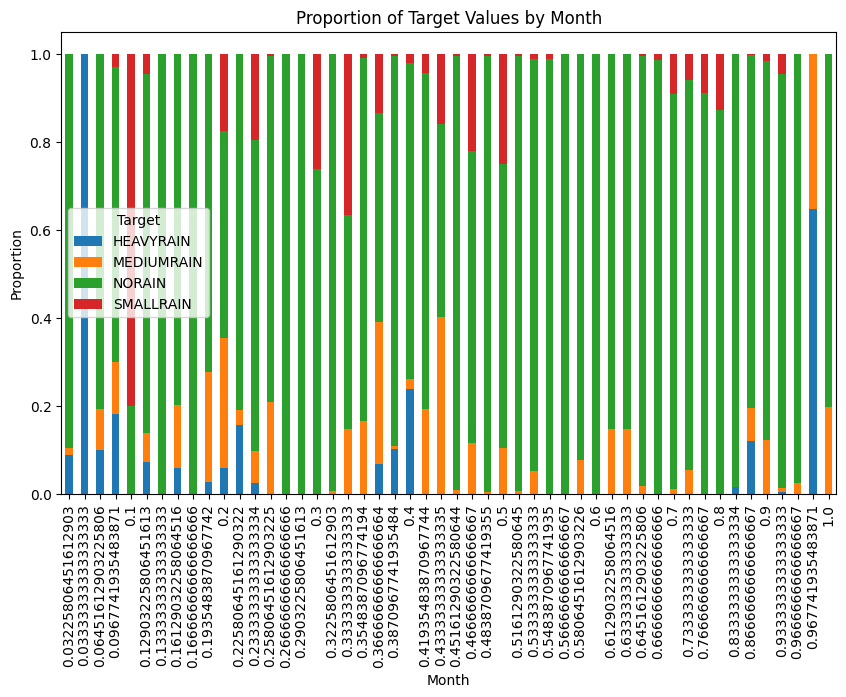

In [28]:
# Group by month and target, count occurrences
monthly_target = train_data.groupby(["monthprogress", "Target"], observed=False).size().unstack(fill_value=0)

# Normalize to proportion
monthly_target_prop = monthly_target.div(monthly_target.sum(axis=1), axis=0)

# Plot counts
monthly_target_prop.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.title("Proportion of Target Values by Month")
plt.legend(title="Target")
plt.show();

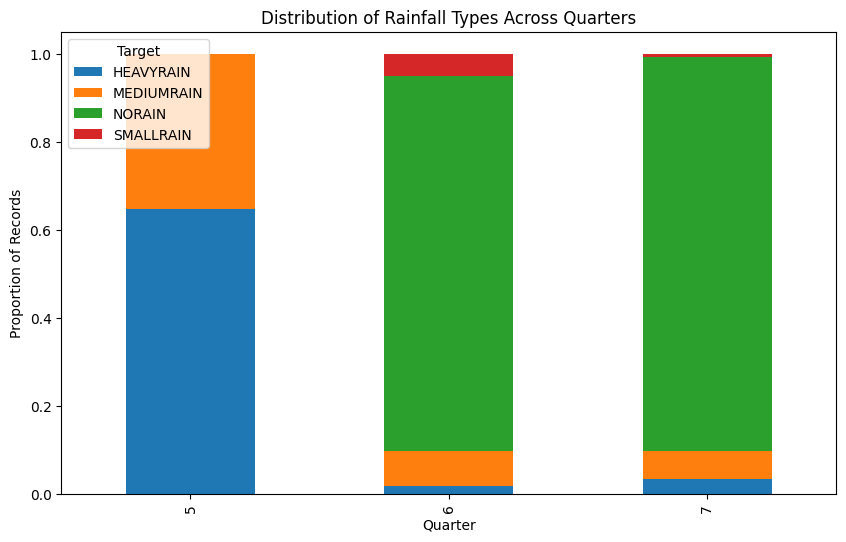

In [29]:
# Group by quarter and Target
quarterly_target = train_data.groupby(["month", "Target"], observed=False).size().unstack(fill_value=0)

# Normalize to proportions
quarterly_target_prop = quarterly_target.div(quarterly_target.sum(axis=1), axis=0)

# Plot
quarterly_target_prop.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Distribution of Rainfall Types Across Quarters")
plt.xlabel("Quarter")
plt.ylabel("Proportion of Records")
plt.legend(title="Target")
plt.show()

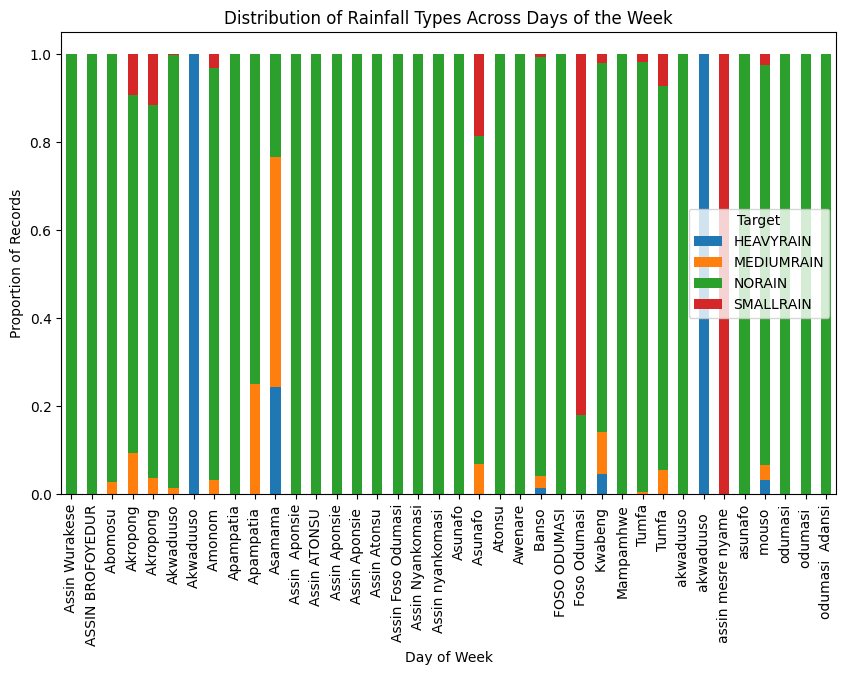

In [30]:
# Group by day of week and Target
weekday_target = train_data.groupby(["community", "Target"], observed=False).size().unstack(fill_value=0)

# Normalize to proportions
weekday_target_prop = weekday_target.div(weekday_target.sum(axis=1), axis=0)

# Plot
weekday_target_prop.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Distribution of Rainfall Types Across Days of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Proportion of Records")
plt.legend(title="Target")
plt.show()

#### Understanding Class Imbalance

Target distribution (%): 
 Target
NORAIN        87.958
MEDIUMRAIN     6.964
HEAVYRAIN      2.883
SMALLRAIN      2.196
Name: proportion, dtype: float64


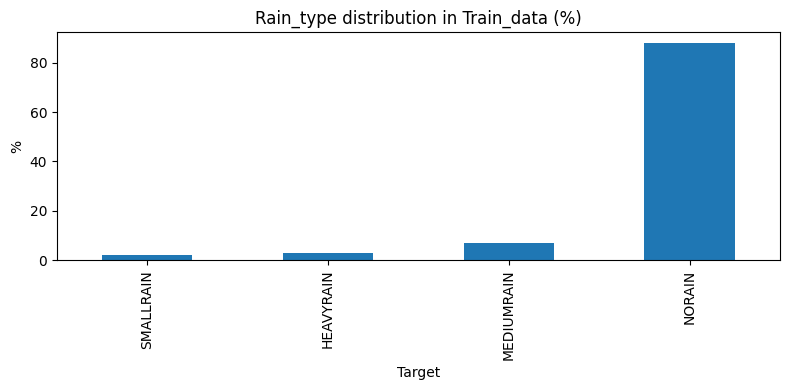

In [31]:
if "Target" in train_data.columns:
  target_counts = train_data["Target"].value_counts(normalize = True).mul(100).round(3)
  print("Target distribution (%): \n", target_counts)

  plt.figure(figsize=(8,4))
  target_counts.sort_values().plot(kind='bar')
  plt.title("Rain_type distribution in Train_data (%)")
  plt.ylabel("%")
  plt.tight_layout()
  plt.show()

### Model Building

In [33]:
# Features & Target
target_col = "Target"
feature_cols = [col for col in train_data.columns if col != target_col]

# Drop unwanted IDs if present
drop_cols = [col for col in ["ID"] if col in train_data.columns]

# Separate categorical & numeric
num_features = ["confidence", "hour_ratio"]
cat_features = ["month", "community", "monthprogress", "indicator", "day", "district", "weekofmonth", "days_in_month", "quarter"]

X = train_data[cat_features + num_features]
y = train_data[target_col]

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Preprocessing
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[("cat", cat_transformer, cat_features)],
    remainder="passthrough"
)


# Model
model = RandomForestClassifier(
    n_estimators= 58,
    max_depth = None,
    criterion = "log_loss",
    n_jobs=-1,
    random_state=24,

)

# Pipeline
model_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "accuracy": make_scorer(accuracy_score)
}

# Cross-validation
scores = cross_validate(
    model_pipe,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

print("F1 macro per fold:", scores["test_f1_macro"])
print("Mean F1 Score:", scores["test_f1_macro"].mean())
print("Accuracy per fold:", scores["test_accuracy"])
print("Mean Accuracy:", scores["test_accuracy"].mean())

# Final fit on all data
model_pipe.fit(X, y)

F1 macro per fold: [0.95956677 0.9792743  0.98462461 0.96523086 0.95654311]
Mean F1 Score: 0.9690479325740391
Accuracy per fold: [0.98993596 0.99451052 0.99588289 0.99313501 0.99130435]
Mean Accuracy: 0.9929537455955415


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
test_data

,ID,user_id,confidence,predicted_intensity,community,district,forecast_length,hour_ratio,dayofweek,quarter,yearprogress,weekofmonth,day,month,days_in_month,monthprogress,indicator
0,ID_SbTdy_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,6,3,0.583333,3,20,7,31,0.645161,clouds
1,ID_SBKYz_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,6,3,0.583333,3,20,7,31,0.645161,clouds
2,ID_fAimg_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,6,3,0.583333,3,20,7,31,0.645161,clouds
3,ID_2wBqC_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,6,3,0.583333,3,20,7,31,0.645161,clouds
4,ID_NItox_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,6,3,0.583333,3,20,7,31,0.645161,clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,ID_junNZ_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,0,3,0.666667,1,4,8,31,0.129032,clouds
2728,ID_epV8F_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,0,3,0.666667,1,4,8,31,0.129032,clouds
2729,ID_Ai4e0_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,24,0.791667,0,3,0.666667,1,4,8,31,0.129032,clouds
2730,ID_7kXrV_24,18,0.3,0.0,Akwaduuso,assin_fosu,24,0.791667,0,3,0.666667,1,4,8,31,0.129032,clouds


In [38]:
x_test = test_data[cat_features + num_features]
# Predict on test_data
y_pred = model_pipe.predict(x_test)

# Inverse transform labels to original names
y_pred_original = label_encoder.inverse_transform(y_pred)

# attach prediction back to test set
test_data["Target"] = y_pred_original

# View predictions 
test_data[["ID","Target"]]

,ID,Target
0,ID_SbTdy_24,NORAIN
1,ID_SBKYz_24,NORAIN
2,ID_fAimg_24,NORAIN
3,ID_2wBqC_24,NORAIN
4,ID_NItox_24,NORAIN
...,...,...
2727,ID_junNZ_24,NORAIN
2728,ID_epV8F_24,NORAIN
2729,ID_Ai4e0_24,NORAIN
2730,ID_7kXrV_24,NORAIN
